# Fine-Tuning a Semantic Segmentation Model on a Custom Dataset and Usage via the Inference API


Basado en: _[Sergio Paniego](https://github.com/sergiopaniego)_

_(Descripción original)_

In this notebook, we will walk through the process of fine-tuning a [semantic segmentation](https://huggingface.co/tasks/image-segmentation) model on a custom dataset. The model we'll be using is the pretrained [Segformer](https://huggingface.co/docs/transformers/model_doc/segformer), a powerful and flexible transformer-based architecture for segmentation tasks.

![Segformer architecture](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/segformer_architecture.png)

## Adecuación del dataset

El notebook original fue realizado tomando como base [sidewalk-semantic](https://huggingface.co/datasets/segments/sidewalk-semantic). A continuación se adapta el dataset propio a este formato para evitar incompatibilidades con el modelo a _fine tunnear_.

In [1]:
import os
import json
import pandas as pd
from datasets import DatasetDict, Dataset
from PIL import Image
import numpy as np

import sys
sys.path.append('../utils')

from utils import tabulate_jsons_from_folder, load_image_mask_pairs

d:\Github\Block-Detection\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metadata_path = '../data/metadata'
jsons = tabulate_jsons_from_folder('../data/raw/data_set_256/metadata_y_256/')

In [3]:
jsons[jsons['id']==78]

id  size   row    col  \
7478  78   256  1280  10496   

                                                 bounds  \
7478  {'minx': 620237.39, 'miny': 9245920.040000001,...   

                                       transform_window  crs_epsg  \
7478  [0.7, 0.0, 620237.39, 0.0, -0.7, 9246099.24, 0...     32717   

                                             image_path  \
7478  Perusat\pms_2016_10_1\VOL_PER1_ORT_001_001278\...   

                                               shp_path source_tag  \
7478  manzanas_corregidas/manzanas_3\Manzana_Censal_...       grid   

      mask_pixels                       hash_rgb_u8  num_polygons_in_window  
7478        60681  d972b8be9f6901bc4af8595b8ca5e8b0                       3

In [4]:
l1 = jsons[jsons['num_polygons_in_window']>1]['id']
l0 = jsons[jsons['num_polygons_in_window']==0]['id'].sample(n=int(np.round(len(l1)/5)), random_state=42)
l = pd.concat([l1,l0]) # lista para filtrado de imágenes útiles

In [5]:
# Carga tus datos
train_data = load_image_mask_pairs("../data/raw/data_set_256/dataset_x_256/","../data/raw/data_set_256/dataset_y_256/",l)

In [6]:
# Crea el DatasetDict
dataset = DatasetDict({
    "train": Dataset.from_list(train_data)
})

Separación en test y train



In [7]:
dataset = dataset.shuffle(seed=42)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

## Visualización de ejemplos

In [8]:
import json

filename = "id2label.json"

with open(filename, "r", encoding="utf-8") as f:
    id2label = json.load(f)

#id2label = json.load(open(hf_hub_download(repo_id=sidewalk_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)

Id2label: {0: 'unlabeled', 1: 'Block'}


Asignación de colores por clase

In [9]:
sidewalk_palette = [
  [0, 0, 0], # unlabeled
  [216, 82, 24], # flat-road
]

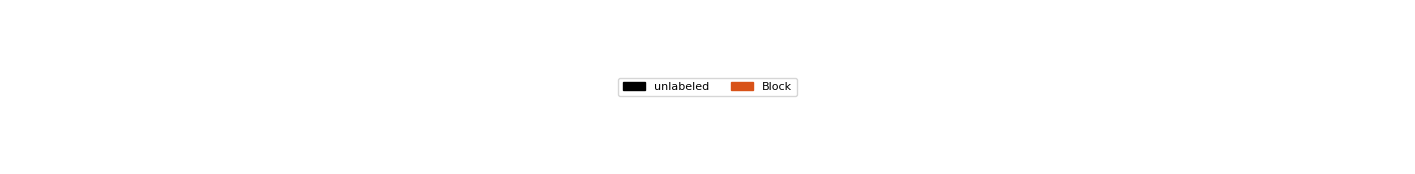

D:\temp\ipykernel_25264\1590348328.py:35: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  colored_mask_img = Image.fromarray(colored_mask, 'RGB')


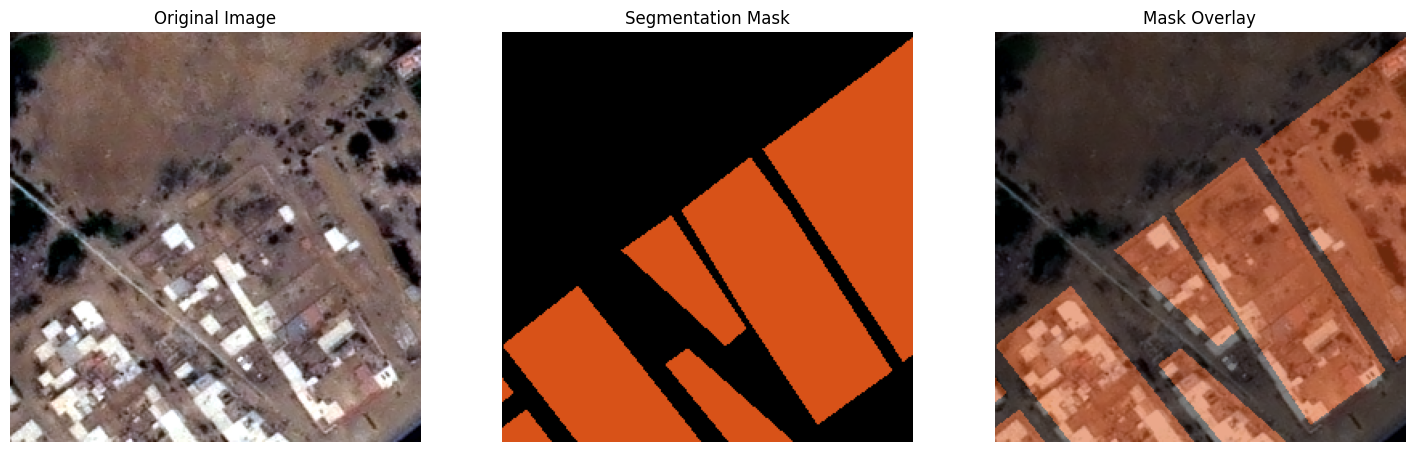

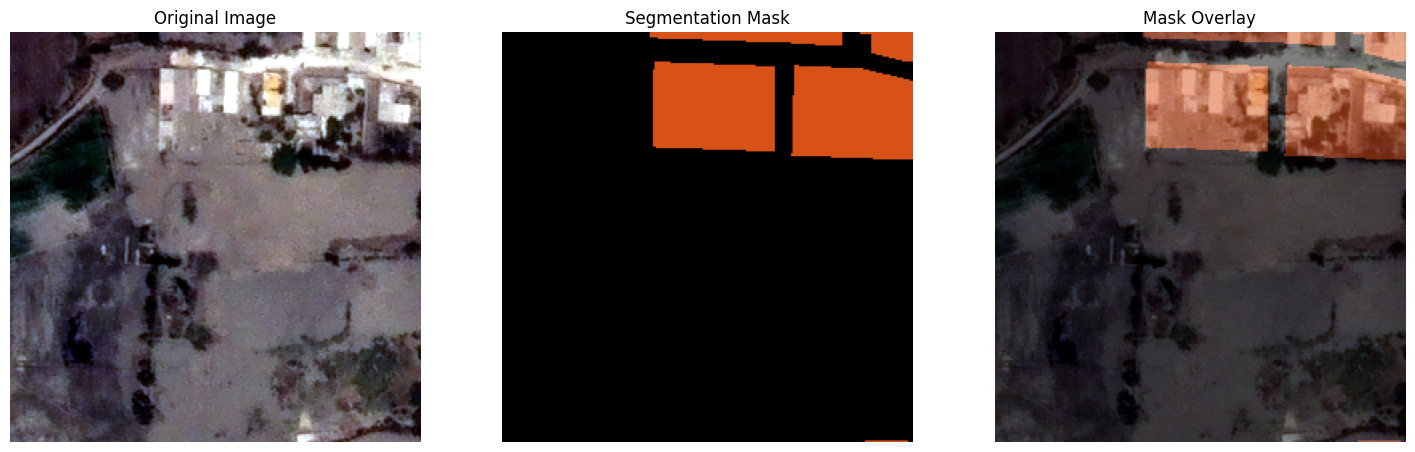

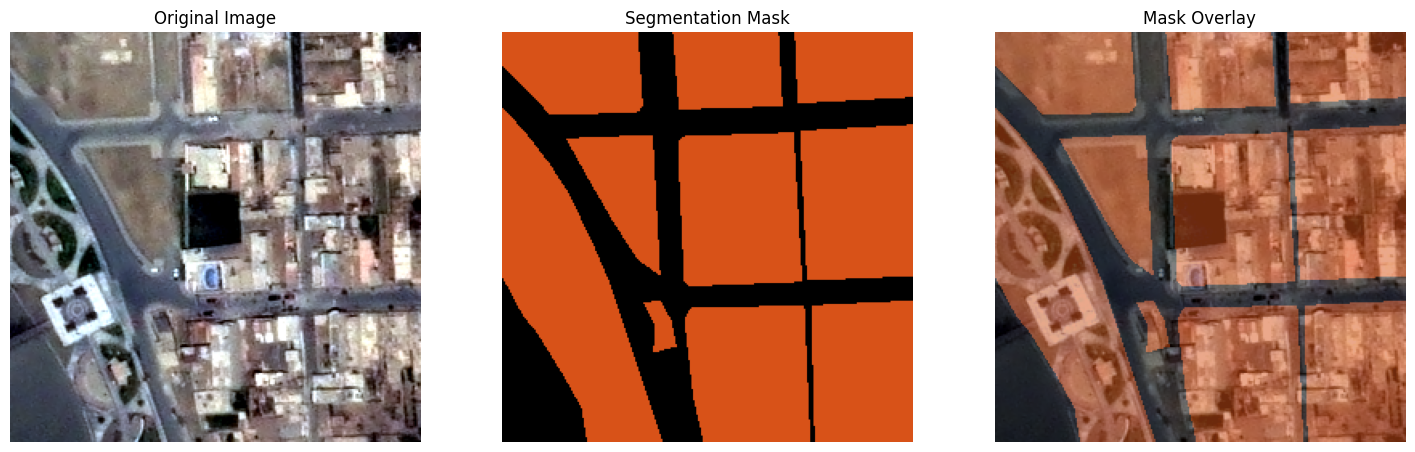

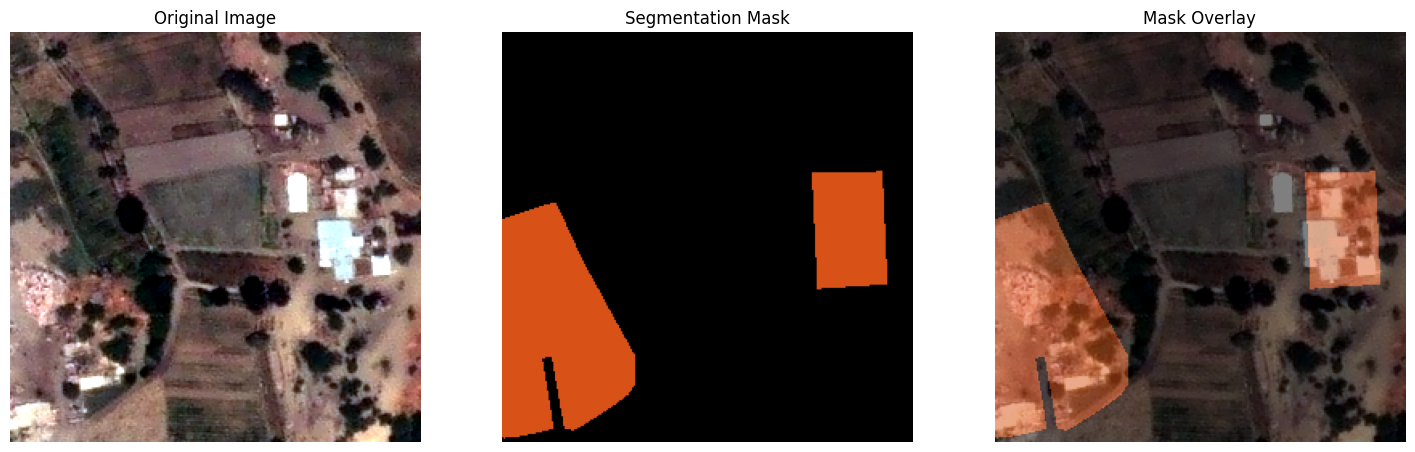

In [10]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches

# Create and show the legend separately
fig, ax = plt.subplots(figsize=(18, 2))

legend_patches = [patches.Patch(color=np.array(color)/255, label=label) for label, color in zip(id2label.values(), sidewalk_palette)]

ax.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.5, 0.5), ncol=5, fontsize=8)
ax.axis('off')

plt.show()

for i in [133,377,288,199]:
    image = train_ds[i]

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Show the original image
    ax[0].imshow(image['pixel_values'])
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    mask_np = np.array(image['label'])

    # Create a new empty RGB image
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    # Assign colors to each value in the mask
    for label_id, color in enumerate(sidewalk_palette):
        colored_mask[mask_np == label_id] = color

    colored_mask_img = Image.fromarray(colored_mask, 'RGB')

    # Show the segmentation mask
    ax[1].imshow(colored_mask_img)
    ax[1].set_title('Segmentation Mask')
    ax[1].axis('off')

    # Convert the original image to RGBA to support transparency
    image_rgba = image['pixel_values'].convert("RGBA")
    colored_mask_rgba = colored_mask_img.convert("RGBA")

    # Adjust transparency of the mask
    alpha = 128  # Transparency level (0 fully transparent, 255 fully opaque)
    image_2_with_alpha = Image.new("RGBA", colored_mask_rgba.size)
    for x in range(colored_mask_rgba.width):
        for y in range(colored_mask_rgba.height):
            r, g, b, a = colored_mask_rgba.getpixel((x, y))
            image_2_with_alpha.putpixel((x, y), (r, g, b, alpha))

    superposed = Image.alpha_composite(image_rgba, image_2_with_alpha)

    # Show the mask overlay
    ax[2].imshow(superposed)
    ax[2].set_title('Mask Overlay')
    ax[2].axis('off')

    plt.show()

## Visualización de las clases en el conjunto del dataset

In [11]:
import matplotlib.pyplot as plt
import numpy as np

class_counts = np.zeros(len(id2label))

for example in train_ds:
    mask_np = np.array(example['label'])
    unique, counts = np.unique(mask_np, return_counts=True)
    for u, c in zip(unique, counts):
        class_counts[u] += c

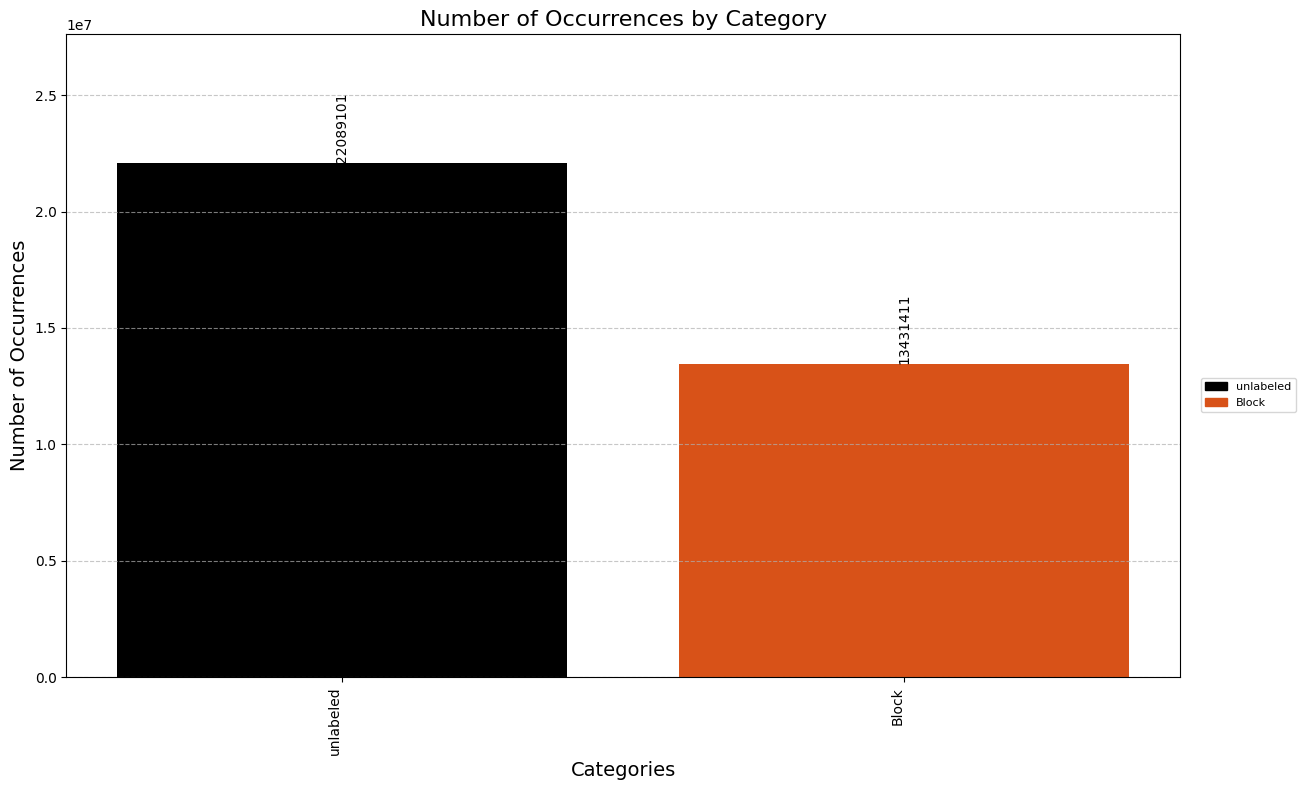

In [12]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import patches

labels = list(id2label.values())

# Normalize colors to be in the range [0, 1]
normalized_palette = [tuple(c / 255 for c in color) for color in sidewalk_palette]

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(range(len(labels)), class_counts, color=[normalized_palette[i] for i in range(len(labels))])

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha="right")

ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Number of Occurrences", fontsize=14)
ax.set_title("Number of Occurrences by Category", fontsize=16)

ax.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust the y-axis limit
y_max = max(class_counts)
ax.set_ylim(0, y_max * 1.25)

for bar in bars:
    height = int(bar.get_height())
    offset = 10  # Adjust the text location
    ax.text(bar.get_x() + bar.get_width() / 2.0, height + offset, f"{height}",
            ha="center", va="bottom", rotation=90, fontsize=10, color='black')

fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=8)  # Adjust ncol as needed

plt.tight_layout()
plt.show()


## Data Augmentation with Albumentations 

Pendiente de implementar


In [13]:
from transformers import SegformerImageProcessor

image_processor = SegformerImageProcessor()

import albumentations as A
albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.7),
    #A.RandomResizedCrop(height=100, width=100, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=25, val_shift_limit=20, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.GaussNoise(var_limit=(10, 50), p=0.4),
])

def train_transforms(example_batch):
    augmented = [
        albumentations_transform(image=np.array(image), mask=np.array(label))
        for image, label in zip(example_batch['pixel_values'], example_batch['label'])
    ]
    augmented_images = [item['image'] for item in augmented]
    augmented_labels = [item['mask'] for item in augmented]
    inputs = image_processor(augmented_images, augmented_labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = image_processor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

d:\Github\Block-Detection\venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
D:\temp\ipykernel_25264\2646983409.py:13: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.4),


In [14]:
train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 542
})

In [15]:
test_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 136
})

In [16]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 7. Establecimiento de hiperparámetros


In [26]:
from transformers import TrainingArguments

output_dir = "segformer-finetuned-200"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=6e-5,
    num_train_epochs=200,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=1,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,          
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to=None
)

In [27]:
#import wandb

#wandb.init(
#    project="test-segformer-b0-segments-sidewalk-finetuned",  # change this
#    name="test-segformer-b0-segments-sidewalk-finetuned",  # change this
#    config=training_args,
#)

## 8. Set Custom `compute_metrics` Method for Enhanced Logging with `evaluate`

We will use the [mean Intersection over Union (mean IoU)](https://huggingface.co/spaces/evaluate-metric/mean_iou) as the primary metric to evaluate the model’s performance. This will allow us to track performance across each category in detail.

Additionally, we’ll adjust the logging level of the evaluation module to minimize warnings in the output. If a category is not detected in an image, you might see warnings like the following:

```
RuntimeWarning: invalid value encountered in divide iou = total_area_intersect / total_area_union
```


You can skip this cell if you prefer to see these warnings and proceed to the next step.


In [28]:
import evaluate
evaluate.logging.set_verbosity_error()

In [29]:
import torch
from torch import nn
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    # currently using _compute instead of compute: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    pred_labels = logits_tensor.detach().cpu().numpy()
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=0,
                reduce_labels=image_processor.do_reduce_labels,
            )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

## 9. Train the Model on Our Dataset 🏋

Now it's time to train the model on our custom dataset. We’ll use the prepared training arguments and the connected Weights & Biases integration to monitor the training process and make adjustments as needed. Let’s start the training and watch the model improve its performance!


In [30]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=30)],
    compute_metrics=compute_metrics,
)

D:\temp\ipykernel_25264\3967264545.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [31]:
trainer.train()

KeyboardInterrupt: 

## 10. Evaluate Model Performance on New Images 📸

After training, we’ll assess the model’s performance on new images. We’ll use a test image and leverage a [pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines) to evaluate how well the model performs on unseen data.


In [ ]:
import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

#url = "https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

#image = Image.open(requests.get(url, stream=True).raw)


ruta_imagen = "prueba.png"  # Cambia por la ruta real

# Abrir la imagen
image = Image.open(ruta_imagen)


image_segmentator = pipeline(
    "image-segmentation", model="segformer-finetuned/checkpoint-1080" # Change with your model name
)

results = image_segmentator(image)

Device set to use cuda:0


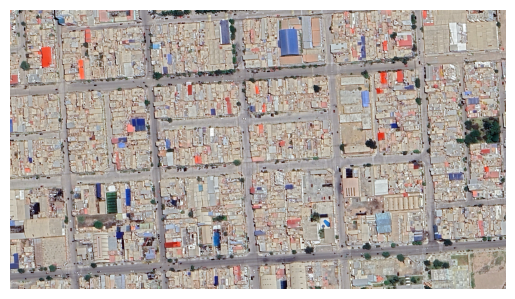

In [ ]:
plt.imshow(image)
plt.axis('off')
plt.show()

The model has generated some masks, so we can visualize them to evaluate and understand its performance. This will help us see how well the model is segmenting the images and identify any areas for improvement.


In [ ]:
id2label

{0: 'unlabeled', 1: 'Block'}

In [ ]:
label

'flat-sidewalk'

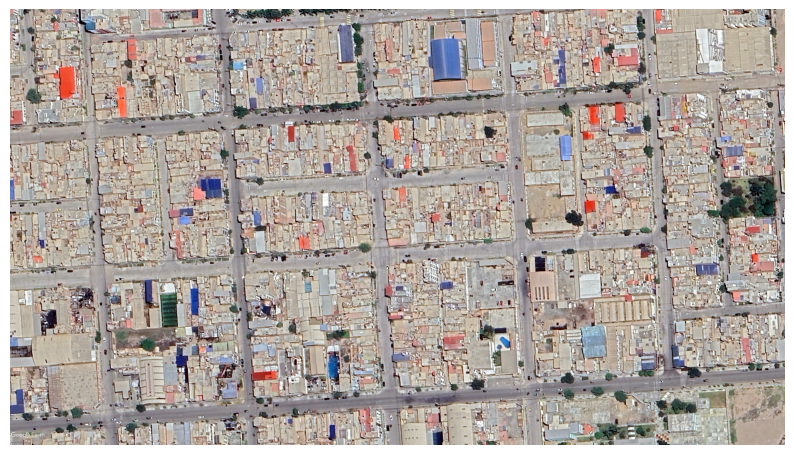

In [ ]:
image_array = np.array(image)

segmentation_map = np.zeros_like(image_array)

for result in results:
    mask = np.array(result['mask'])
    label = result['label']

    label_index = list(id2label.values()).index(label)

    color = sidewalk_palette[label_index]

    for c in range(3):
        segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

plt.figure(figsize=(10, 10))
plt.imshow(image_array)
plt.imshow(segmentation_map, alpha=0.5)
plt.axis('off')
plt.show()

## 11. Evaluate Performance on the Test Set 📊


In [ ]:
metrics = trainer.evaluate(test_ds)
print(metrics)

{'eval_loss': 0.38096383213996887, 'eval_mean_iou': 0.36776184016827385, 'eval_mean_accuracy': 0.7355236803365477, 'eval_overall_accuracy': 0.7355236803365477, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_Block': 0.7355236803365477, 'eval_iou_unlabeled': 0.0, 'eval_iou_Block': 0.7355236803365477, 'eval_runtime': 7.2452, 'eval_samples_per_second': 18.771, 'eval_steps_per_second': 2.346, 'epoch': 20.0}


## 12. Access the Model Using the Inference API and Visualize Results 🔌


Hugging Face 🤗 provides a [Serverless Inference API](https://huggingface.co/docs/api-inference/index) that allows you to test models directly via API endpoints for free. For detailed guidance on using this API, check out this [cookbook](https://huggingface.co/learn/cookbook/enterprise_hub_serverless_inference_api).

We will use this API to explore its functionality and see how it can be leveraged for testing our model.

**IMPORTANT**

Before using the Serverless Inference API, you need to set the model task by creating a model card. When creating the model card for your fine-tuned model, ensure that you specify the task appropriately.

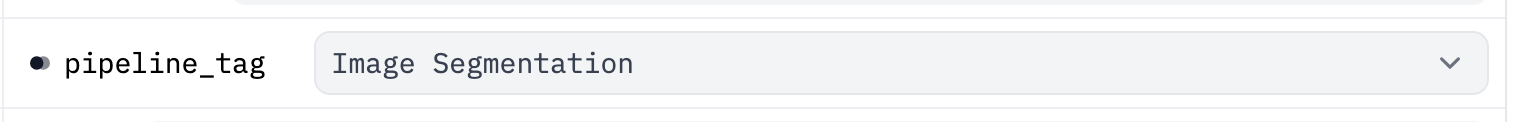


Once the model task is set up, we can download an image and use the [InferenceClient](https://huggingface.co/docs/huggingface_hub/v0.25.0/en/package_reference/inference_client) to test the model. This client will allow us to send the image to the model through the API and retrieve the results for evaluation.


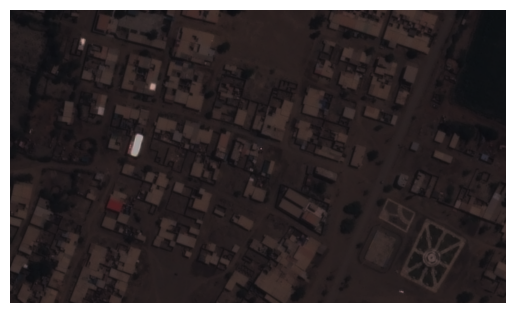

In [ ]:
#url = "https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
#image = Image.open(requests.get(url, stream=True).raw)
ruta_imagen = "prueba3.png"  # Cambia por la ruta real

# Abrir la imagen
image = Image.open(ruta_imagen)
plt.imshow(image)
plt.axis('off')
plt.show()

We will use the [image_segmentation](https://huggingface.co/docs/huggingface_hub/v0.25.0/en/package_reference/inference_client#huggingface_hub.InferenceClient.image_segmentation) method from the InferenceClient. This method takes the model and an image as inputs and returns the predicted masks. This will allow us to test how well the model performs on new images.


In [ ]:
[x for x in jsons[jsons['num_polygons_in_window']==1]['id']]

[1091,
 117,
 118,
 1184,
 127,
 1280,
 131,
 1472,
 153,
 154,
 1566,
 157,
 1571,
 1572,
 160,
 1663,
 169,
 1731,
 1733,
 1734,
 1735,
 1797,
 1799,
 1828,
 1831,
 1856,
 1858,
 1896,
 1927,
 1952,
 1953,
 196,
 197,
 199,
 1990,
 1991,
 2016,
 203,
 204,
 2048,
 2049,
 205,
 206,
 2085,
 2086,
 2087,
 210,
 2143,
 215,
 2182,
 2183,
 2209,
 2217,
 2238,
 2239,
 2240,
 2277,
 2304,
 2334,
 2335,
 2367,
 2405,
 2406,
 2429,
 2430,
 246,
 2462,
 2464,
 2495,
 2525,
 2526,
 2527,
 257,
 2591,
 2620,
 2652,
 2690,
 2715,
 2720,
 2721,
 2747,
 2879,
 2880,
 2905,
 2914,
 2976,
 2979,
 3002,
 305,
 3069,
 3073,
 3107,
 3168,
 3203,
 3204,
 3221,
 3231,
 3232,
 3256,
 3263,
 3350,
 3387,
 3394,
 3395,
 3414,
 3445,
 3446,
 3455,
 3541,
 3580,
 3607,
 3608,
 3611,
 362,
 3704,
 3705,
 3732,
 3828,
 3829,
 4005,
 4007,
 4008,
 4100,
 4103,
 4199,
 426,
 428,
 4290,
 4391,
 4848,
 4857,
 5039,
 5134,
 5135,
 5138,
 5419,
 556,
 5611,
 563,
 5712,
 5803,
 5807,
 5997,
 6089,
 6092,
 6093,
 624

Device set to use cuda:0


[{'score': None, 'label': 'unlabeled', 'mask': <PIL.Image.Image image mode=L size=256x256 at 0x2C030402890>}, {'score': None, 'label': 'Block', 'mask': <PIL.Image.Image image mode=L size=256x256 at 0x2C030401EA0>}]


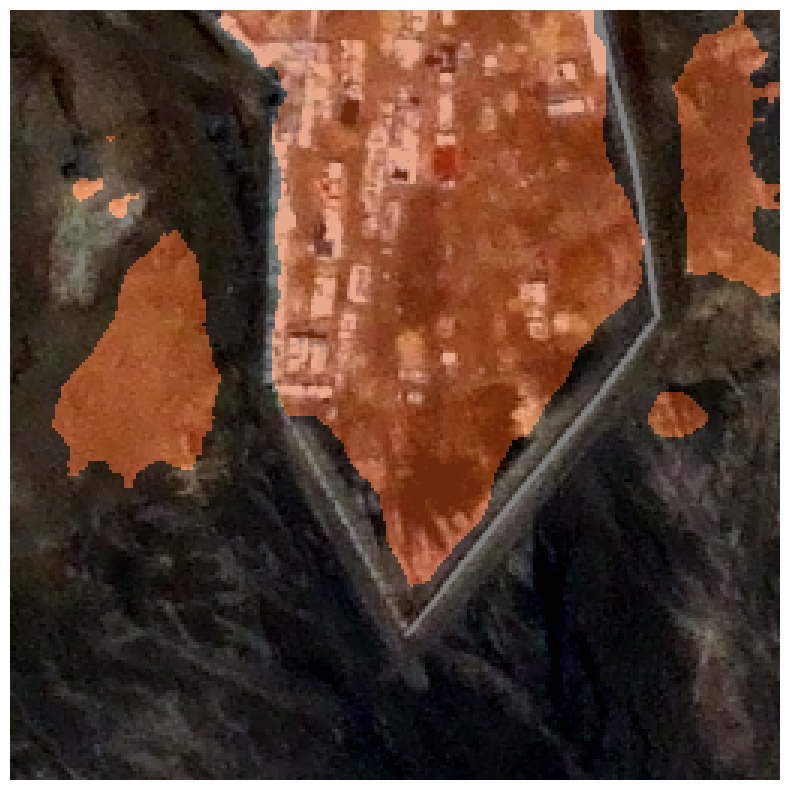

In [ ]:
from transformers import pipeline

# Ruta al modelo entrenado localmente
local_model_path = "segformer-finetuned/checkpoint-1080"  # Ajusta según tu ruta real

# Crear el pipeline para segmentación de imágenes
image_segmentator = pipeline(
    task="image-segmentation",
    model=local_model_path
)

# Abrir imagen local
from PIL import Image
image_path = "data/images/5807.png"  # Cambia por tu imagen
image = Image.open(image_path)

# Realizar la predicción
result = image_segmentator(image)
print(result)

image_array = np.array(image)
segmentation_map = np.zeros_like(image_array)

for result in result:
    mask = np.array(result['mask'])
    label = result['label']

    label_index = list(id2label.values()).index(label)

    color = sidewalk_palette[label_index]

    for c in range(3):
        segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

plt.figure(figsize=(10, 10))
plt.imshow(image_array)
plt.imshow(segmentation_map, alpha=0.5)
plt.axis('off')
plt.show()

In [ ]:
from transformers import pipeline, AutoConfig
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Device set to use cuda:0


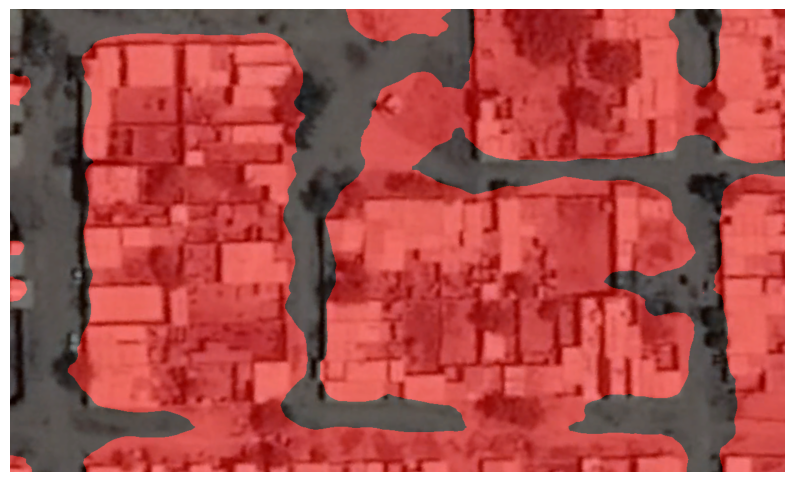

In [ ]:
local_model_path = "segformer-finetuned/checkpoint-1080"

image_segmentator = pipeline(
    task="image-segmentation",
    model=local_model_path
)

image = Image.open("prueba8.png")
result = image_segmentator(image)

# Asegurar lista
if not isinstance(result, list):
    result = [result]

# Tomar primer resultado
r = result[1]

mask = np.array(r["mask"]) > 0   # booleana
color = (255, 0, 0)  # ejemplo: rojo

segmentation_map = np.zeros((*mask.shape, 3), dtype=np.uint8)

for c in range(3):
    segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

img_np = np.array(image)

plt.figure(figsize=(10, 10))
plt.imshow(img_np)
plt.imshow(segmentation_map, alpha=0.5)
plt.axis('off')
plt.show()

In [ ]:
result

[{'score': None,
  'label': 'unlabeled',
  'mask': <PIL.Image.Image image mode=L size=1525x915>},
 {'score': None,
  'label': 'Block',
  'mask': <PIL.Image.Image image mode=L size=1525x915>}]

With the predicted masks, we can display the results.

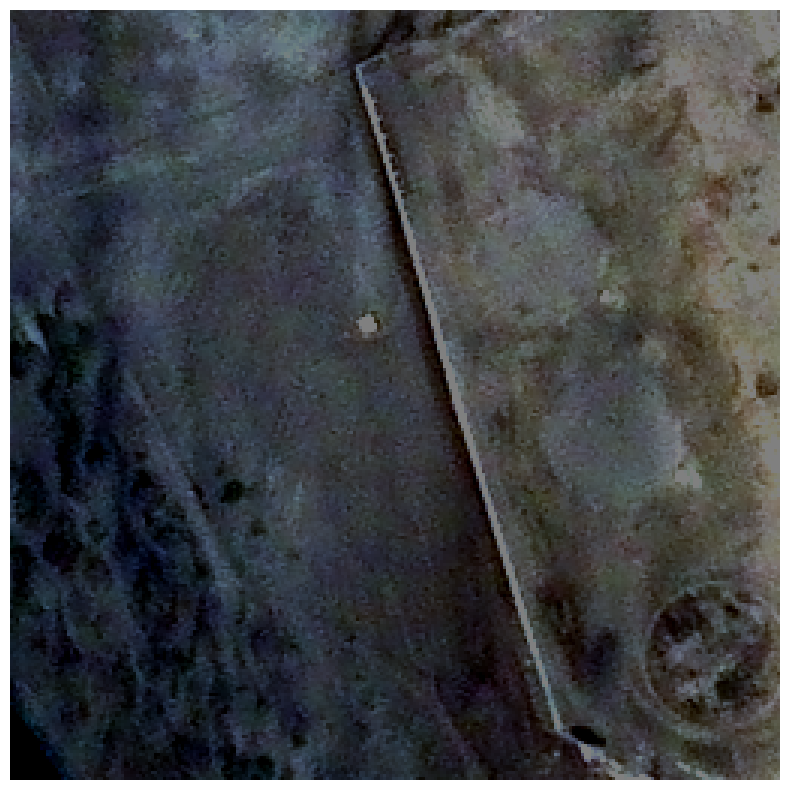

In [ ]:
image_array = np.array(image)
segmentation_map = np.zeros_like(image_array)

for result in result:
    mask = np.array(result['mask'])
    label = result['label']

    label_index = list(id2label.values()).index(label)

    color = sidewalk_palette[label_index]

    for c in range(3):
        segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

plt.figure(figsize=(10, 10))
plt.imshow(image_array)
plt.imshow(segmentation_map, alpha=0.5)
plt.axis('off')
plt.show()

It’s also possible to use the [Inference API with JavaScript](https://huggingface.co/tasks/image-segmentation). Here’s an example of how you can consume the API using JavaScript:

```
import { HfInference } from "@huggingface/inference";

const inference = new HfInference(HF_TOKEN);
await inference.imageSegmentation({
    data: await (await fetch("https://picsum.photos/300/300")).blob(),
    model: "sergiopaniego/segformer-b0-segments-sidewalk-finetuned",
});

```



**Extra Points**

You can also deploy the fine-tuned model using a Hugging Face Space. For example, I have created a custom Space to showcase this: [Semantic Segmentation with SegFormer Fine-Tuned on Segments/Sidewalk](https://huggingface.co/spaces/sergiopaniego/segformer-b0-segments-sidewalk-finetuned).

<img src="https://huggingface.co/front/thumbnails/spaces.png" alt="HF Spaces logo" width="20%">


In [ ]:
from IPython.display import IFrame
IFrame(src='https://sergiopaniego-segformer-b0-segments-sidewalk-finetuned.hf.space', width=1000, height=800)

## Conclusion

In this guide, we successfully fine-tuned a semantic segmentation model on a custom dataset and utilized the Serverless Inference API to test it. This demonstrates how easily you can integrate the model into various applications and leverage Hugging Face tools for deployment.

I hope this guide provides you with the tools and knowledge to confidently fine-tune and deploy your own models! 🚀